<a href="https://colab.research.google.com/github/Ibrahim-Khalil07/CHATCAD-Lung-and-Colon-Cancer-/blob/main/Lung_and_Colon_Cancer_Detection_%7C_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
# Generate data paths with labels
data_dir = '/content/drive/MyDrive/Lung and Colon Cancer Histopathological Images/archive/lung_colon_image_set'
# Initialize empty lists to store file paths and labels

filepaths = []
labels = []
# Get a list of subdirectories
folds = os.listdir(data_dir)
# Iterate over each fold in the dataset
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
# Iterate over each file in the current fold
    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)
# Iterate over each file in the current fold
        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)
# Determine the label based on the subdirectory (f)
            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
df

filepaths               labels
0      /content/drive/MyDrive/Lung and Colon Cancer H...  Lung Adenocarcinoma
1      /content/drive/MyDrive/Lung and Colon Cancer H...  Lung Adenocarcinoma
2      /content/drive/MyDrive/Lung and Colon Cancer H...  Lung Adenocarcinoma
3      /content/drive/MyDrive/Lung and Colon Cancer H...  Lung Adenocarcinoma
4      /content/drive/MyDrive/Lung and Colon Cancer H...  Lung Adenocarcinoma
...                                                  ...                  ...
24995  /content/drive/MyDrive/Lung and Colon Cancer H...  Colon Benign Tissue
24996  /content/drive/MyDrive/Lung and Colon Cancer H...  Colon Benign Tissue
24997  /content/drive/MyDrive/Lung and Colon Cancer H...  Colon Benign Tissue
24998  /content/drive/MyDrive/Lung and Colon Cancer H...  Colon Benign Tissue
24999  /content/drive/MyDrive/Lung and Colon Cancer H...  Colon Benign Tissue

[25000 rows x 2 columns]

In [6]:
labels = df['labels']
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=labels)
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=temp_df['labels'])

In [7]:
# Define image size, channels, and shape
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Create ImageDataGenerator  for training and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Training data generator
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Validation data generator
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

# Testing data generator
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


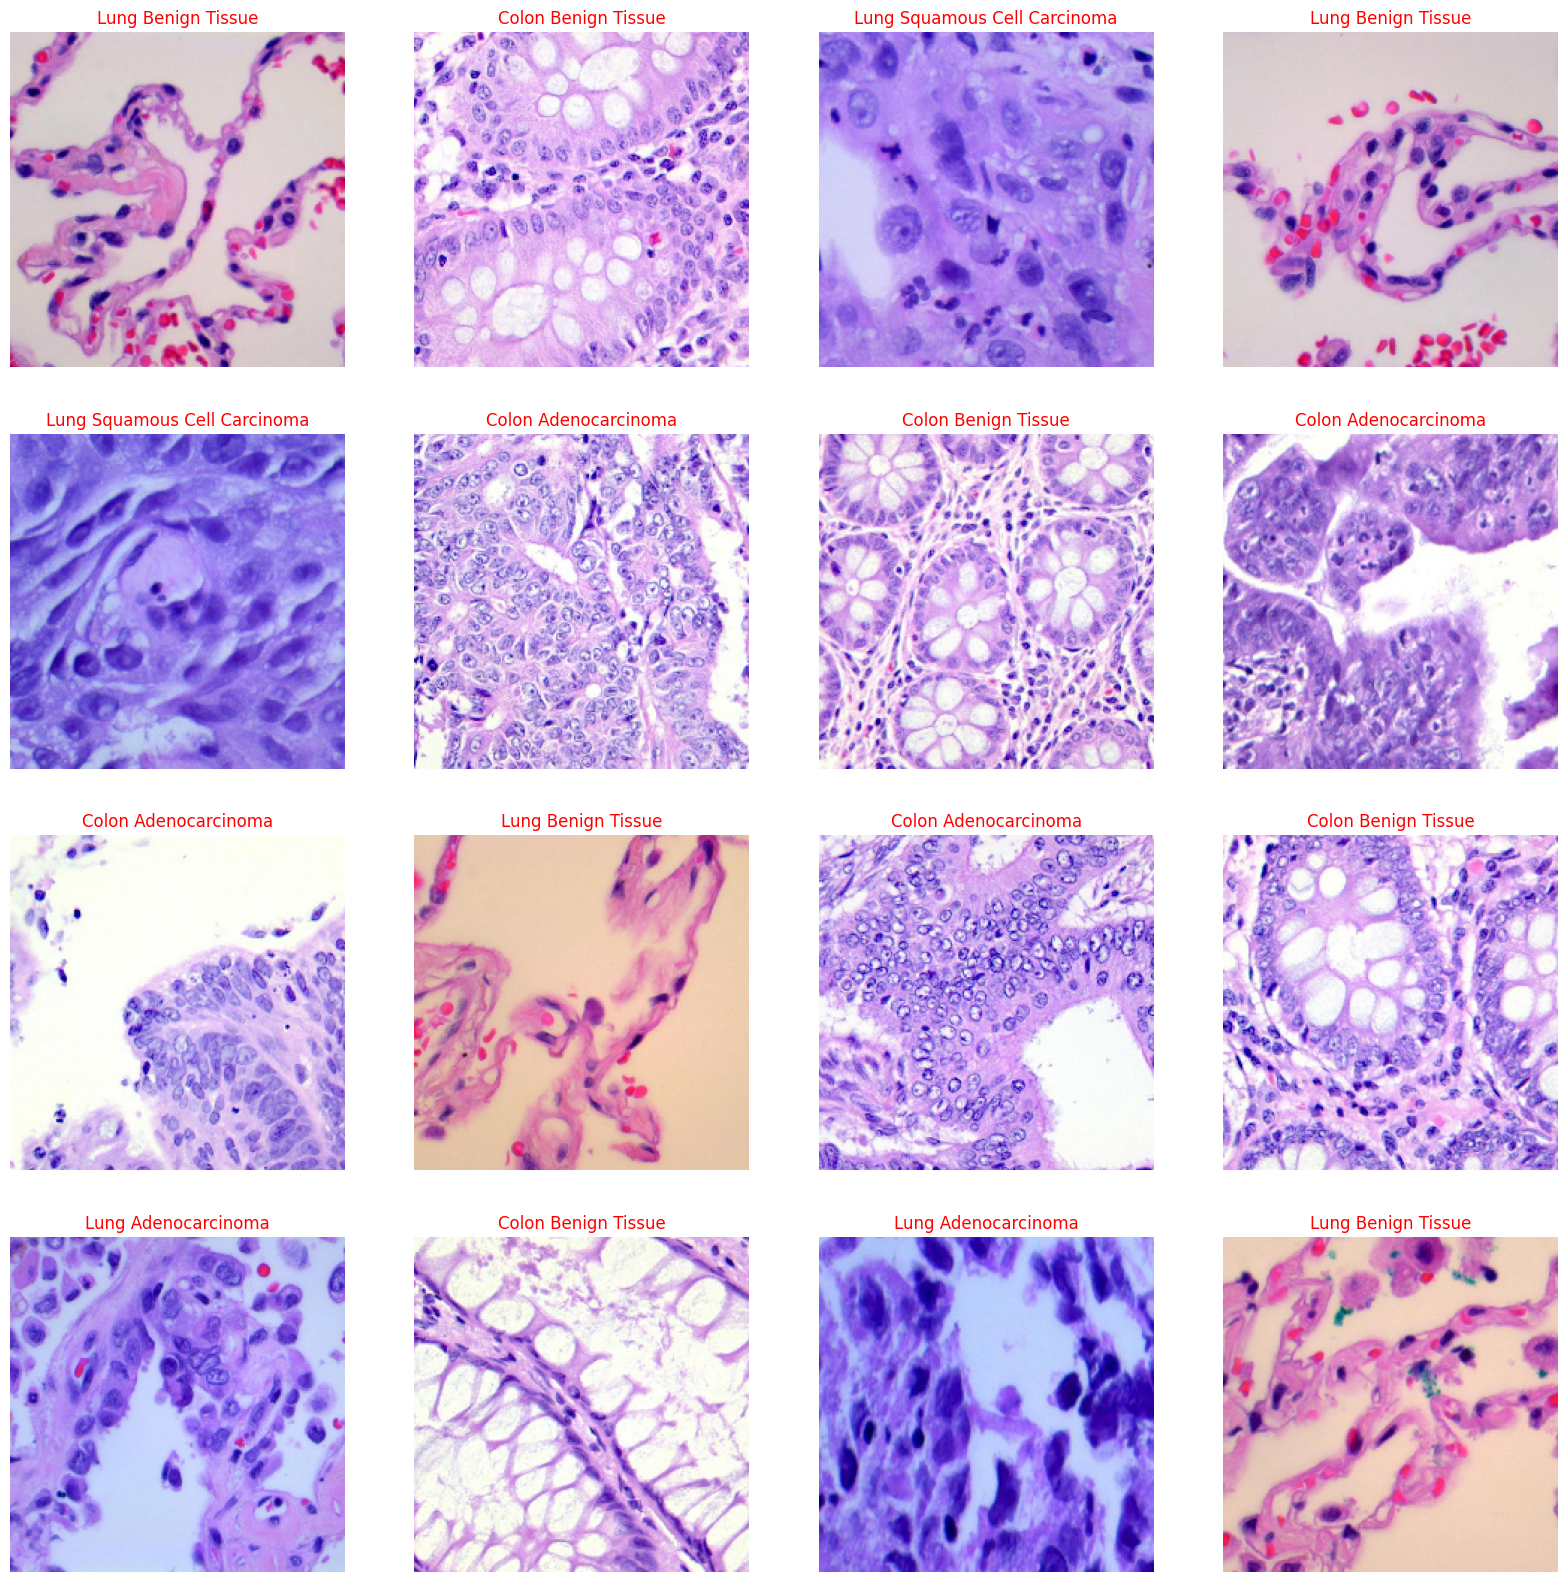

In [8]:
# Get the class Name from the training generator
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='red', fontsize=12)

    plt.axis('off')

plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

In [10]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [11]:
def get_callbacks(model_name):
    callbacks = []

    # Use correct syntax for ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_accuracy', mode='max')
    callbacks.append(checkpoint)

    # Import ReduceLROnPlateau if not imported earlier
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    callbacks.append(reduce_lr)

    # Import EarlyStopping if not imported earlier
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    callbacks.append(early_stopping)

    return callbacks

In [12]:
# Create Xception base model
base_model = Xception(input_shape=img_shape, include_top=False, weights='imagenet')

base_model.trainable = True

x = base_model.output

x = GlobalAveragePooling2D()(x)

y = Dense(256, activation='relu')(x)

predictions = Dense(class_count, activation='softmax', name='final')(y)

model_Xception = Model(inputs=base_model.input, outputs=predictions)


model_Xception.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

83683744/83683744 [==============================] - 0s 0us/step


In [13]:
print(model_Xception.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

In [14]:
callbacks=get_callbacks('Xception')
history_Xception=model_Xception.fit(train_gen,epochs=5,validation_data=valid_gen,callbacks=[callbacks])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9798 
Epoch 1: saving model to model.Xception.h5
313/313 [==============================] - 4871s 15s/step - loss: 0.0556 - accuracy: 0.9798 - val_loss: 0.0363 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.9984
Epoch 2: saving model to model.Xception.h5
313/313 [==============================] - 318s 1s/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0043 - val_accuracy: 0.9988 - lr: 0.0010
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9974
Epoch 3: saving model to model.Xception.h5
313/313 [==============================] - 320s 1s/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0032 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9995
Epoch 4: saving model to model.Xception.h5
313/313 [=

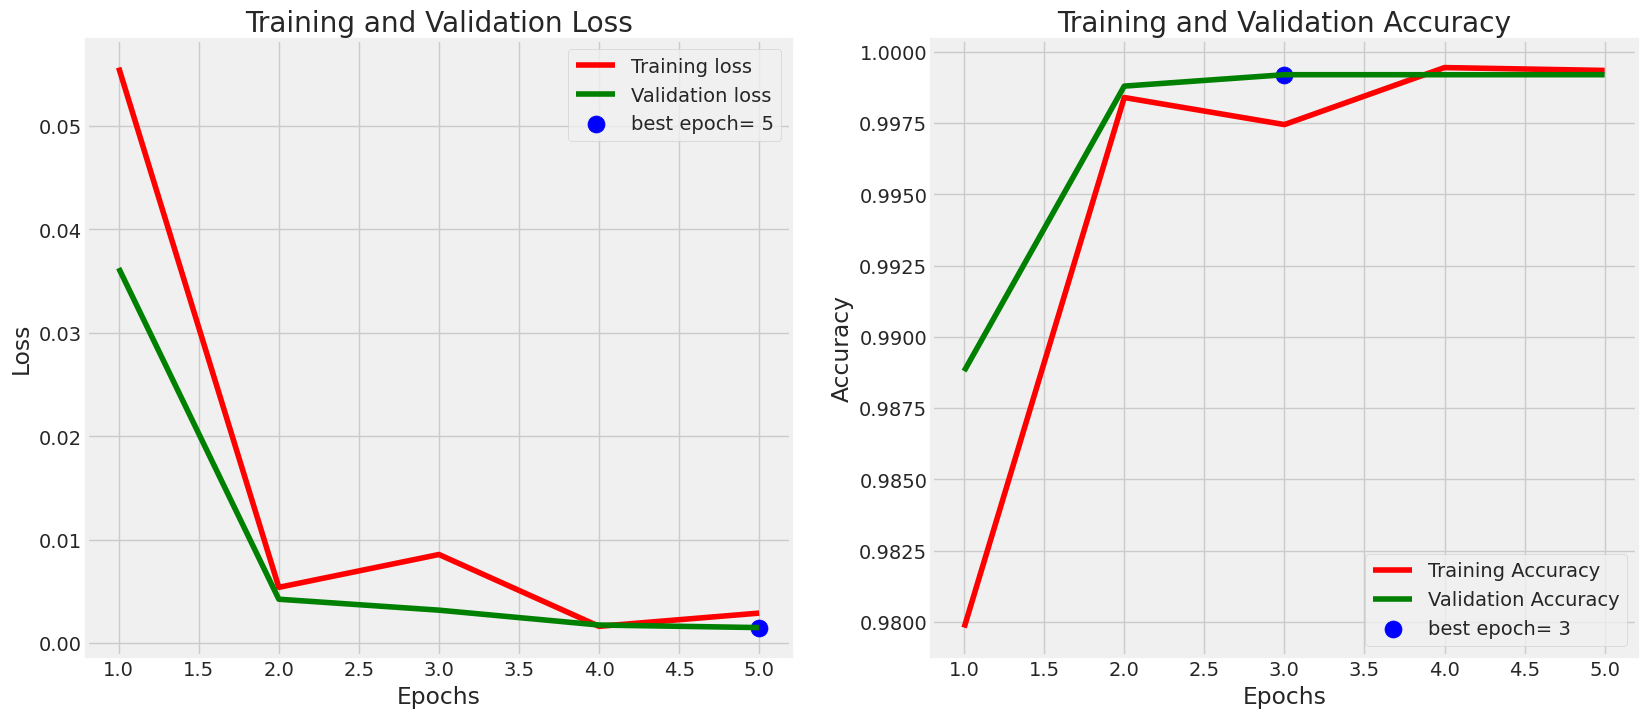

In [15]:
tr_acc = history_Xception.history['accuracy']
tr_loss = history_Xception.history['loss']
val_acc = history_Xception.history['val_accuracy']
val_loss = history_Xception.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [16]:
ts_length = len(test_df)
# Choose a suitable test batch size (smaller than the training batch size)
test_batch_size = min(64, ts_length)
test_steps = ts_length // test_batch_size

train_score = model_Xception.evaluate(train_gen, steps=test_steps, verbose=1)
valid_score = model_Xception.evaluate(valid_gen, steps=test_steps, verbose=1)
test_score = model_Xception.evaluate(test_gen, steps=test_steps, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

39/39 [==============================] - 516s 14s/step - loss: 0.0025 - accuracy: 0.9988
Train Loss:  7.689148333156481e-05
Train Accuracy:  1.0
--------------------
Valid Loss:  0.0015112614491954446
Valid Accuracy:  0.9991987347602844
--------------------
Test Loss:  0.002536602783948183
Test Accuracy:  0.9987980723381042


In [17]:
preds = model_Xception.predict_generator(test_gen)
y_pred_Xception = np.argmax(preds, axis=1)

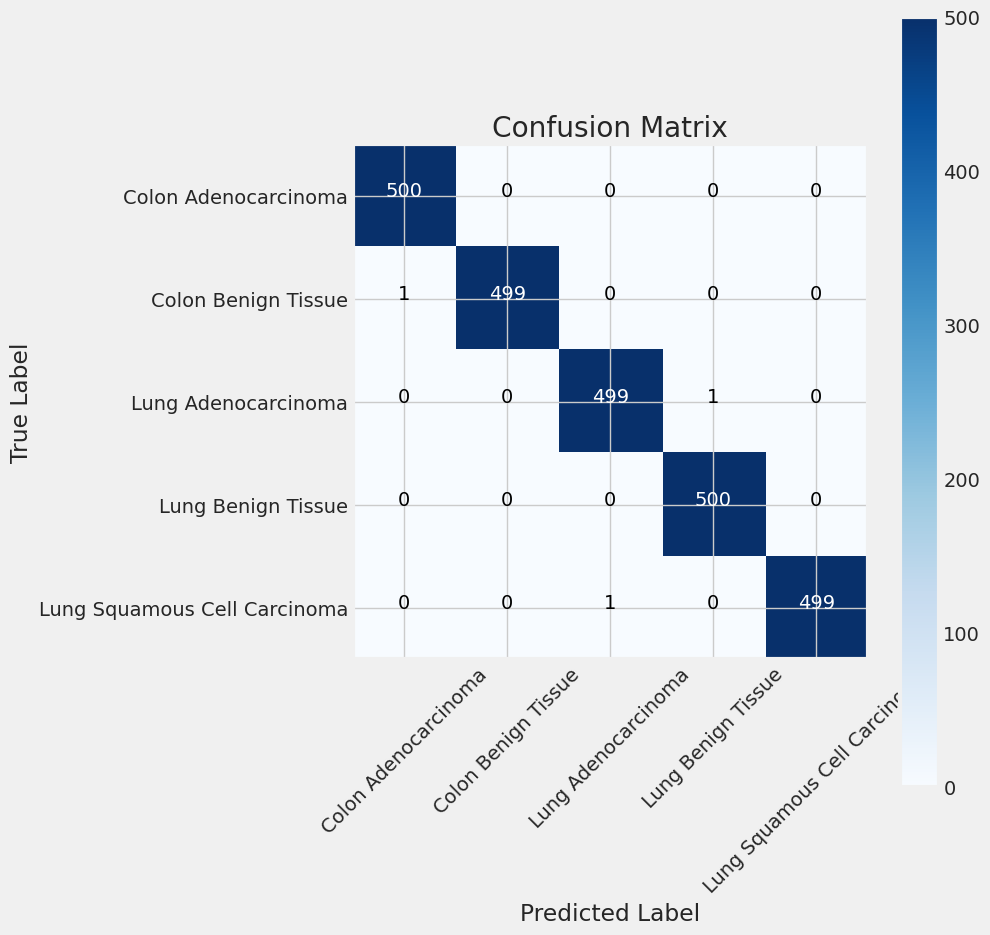

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred_Xception)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [19]:
print(classification_report(test_gen.classes, y_pred_Xception, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       1.00      1.00      1.00       500
         Colon Benign Tissue       1.00      1.00      1.00       500
         Lung Adenocarcinoma       1.00      1.00      1.00       500
          Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cell Carcinoma       1.00      1.00      1.00       500

                    accuracy                           1.00      2500
                   macro avg       1.00      1.00      1.00      2500
                weighted avg       1.00      1.00      1.00      2500

